# Load CHB data

## Notes
+ kurtosis increases towards siezure, variance and decorrelation time decreasing in preictal state 

## TODO

In [1]:
# https://github.com/NeuroSyd/seizure-prediction-GAN/blob/master/utils/load_signals.py
import os
import mne
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from pathlib import Path

import scipy.stats as stats
import scipy.signal as signal


# try quick PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


#data_dir = Path('data/chb-mit-scalp-eeg-database-1.0.0')
data_dir = Path('data/chb-mit-2-subjects')


# pd.set_option('display.max_rows', 50)

In [2]:
info_path = 'data/chb-mit-2-subjects/chb01/chb01-summary.txt'


def info_to_df(info_path):
    """Loads summary text file from single subject from CHB-MIT dataset
    
    Splits text files into chunks (text separated by blank lines in summary file). Then parses
    each chunk to extract file/siezure information. Code could be modified to return channel
    info.
    
    Parameters
    ----------
    info_path : str
       Path to summary file (.txt)
        
    Returns
    -------
    df : pd.DataFrame
        Summary info in a dataframe
    """
    with open(info_path, 'r') as infile:
            info_string = infile.read()

    info_array = info_string.split('\n')

    chunked_list = []
    chunk=[]

    for line in info_array:
        if line:
            chunk.append(line)
        elif chunk: # this prevents empty chunks
            chunked_list.append(chunk)
            chunk=[]
    
    file_list = [x for x in chunked_list if 'File Name' in x[0]] # filter only files

    ds = []

    for file in file_list:
        d={}
        for f in file[:4]:
            string = f.split(': ')
            d.update({string[0].replace(' ','_').lower(): string[1]})
            
            
        d.update({'subject':d['file_name'].split('_')[0]})
        
        # read seizures to dict (can do any number of seizures)
        times = []
        for f in file[4:]:
            string = f.split(': ')
            sub = string[1].split(' ')
            times.append(sub[0])
        if times:
            times = np.reshape(times,(int(len(times)/2),2))

        d.update({'seizure_times':times})

        
        ds.append(d)

    return pd.DataFrame(ds)

info_to_df(info_path)

,file_name,file_start_time,file_end_time,number_of_seizures_in_file,subject,seizure_times
0,chb01_01.edf,11:42:54,12:42:54,0,chb01,[]
1,chb01_02.edf,12:42:57,13:42:57,0,chb01,[]
2,chb01_03.edf,13:43:04,14:43:04,1,chb01,"[[2996, 3036]]"
3,chb01_04.edf,14:43:12,15:43:12,1,chb01,"[[1467, 1494]]"
4,chb01_05.edf,15:43:19,16:43:19,0,chb01,[]
5,chb01_06.edf,16:43:26,17:43:26,0,chb01,[]
6,chb01_07.edf,17:43:33,18:43:33,0,chb01,[]
7,chb01_08.edf,18:43:40,19:43:40,0,chb01,[]
8,chb01_09.edf,19:43:56,20:43:56,0,chb01,[]
9,chb01_10.edf,20:44:07,21:44:07,0,chb01,[]


In [3]:
def get_summaries(data_dir):
    """Loads all summary files into a dataframe.
    
    Parameters
    ----------
    data_dir : str
       Path to data CHB-MIT (str or Path object)
        
    Returns
    -------
    df_info : pd.DataFrame
        Summary info dataframe
    """
    
    files = glob.glob(str(data_dir) + "*/*/*.txt")
    dfs = []
    for f in files:
        
        if 'chb24' not in f: # skip odd summary for now
            df = info_to_df(f)
            
            #df["file_path"] = f
            dfs.append(df)

    df_info = pd.concat(dfs)
    df_info.reset_index(drop=True,inplace=True)
    return df_info

df_info = get_summaries(data_dir)
df_info

,file_name,file_start_time,file_end_time,number_of_seizures_in_file,subject,seizure_times
0,chb01_01.edf,11:42:54,12:42:54,0,chb01,[]
1,chb01_02.edf,12:42:57,13:42:57,0,chb01,[]
2,chb01_03.edf,13:43:04,14:43:04,1,chb01,"[[2996, 3036]]"
3,chb01_04.edf,14:43:12,15:43:12,1,chb01,"[[1467, 1494]]"
4,chb01_05.edf,15:43:19,16:43:19,0,chb01,[]
...,...,...,...,...,...,...
73,chb02_31.edf,03:03:33,4:03:33,0,chb02,[]
74,chb02_32.edf,04:03:40,5:03:40,0,chb02,[]
75,chb02_33.edf,05:03:47,6:03:47,0,chb02,[]
76,chb02_34.edf,06:03:55,7:03:55,0,chb02,[]


In [152]:
df_info.number_of_seizures_in_file.astype('int').sum()

10

In [154]:
df_info.query("number_of_seizures_in_file == '1'")

,file_name,file_start_time,file_end_time,number_of_seizures_in_file,subject,seizure_times
2,chb01_03.edf,13:43:04,14:43:04,1,chb01,"[[2996, 3036]]"
3,chb01_04.edf,14:43:12,15:43:12,1,chb01,"[[1467, 1494]]"
14,chb01_15.edf,01:44:44,2:44:44,1,chb01,"[[1732, 1772]]"
15,chb01_16.edf,02:44:51,3:44:51,1,chb01,"[[1015, 1066]]"
17,chb01_18.edf,04:45:06,5:45:06,1,chb01,"[[1720, 1810]]"
20,chb01_21.edf,07:33:46,8:33:46,1,chb01,"[[327, 420]]"
25,chb01_26.edf,12:34:22,13:13:07,1,chb01,"[[1862, 1963]]"
57,chb02_16.edf,09:31:46,9:47:45,1,chb02,"[[130, 212]]"
58,chb02_16+.edf,10:50:23,11:50:23,1,chb02,"[[2972, 3053]]"
61,chb02_19.edf,13:50:45,14:50:45,1,chb02,"[[3369, 3378]]"


# Load data old + MNE plots

Setting up low-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Using matplotlib as 2D backend.


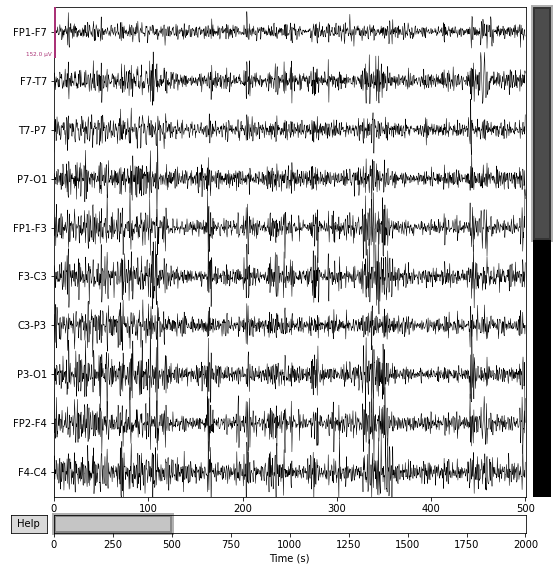

In [6]:
a.plot(duration=500, n_channels=10,scalings='auto',lowpass=True)
plt.show()

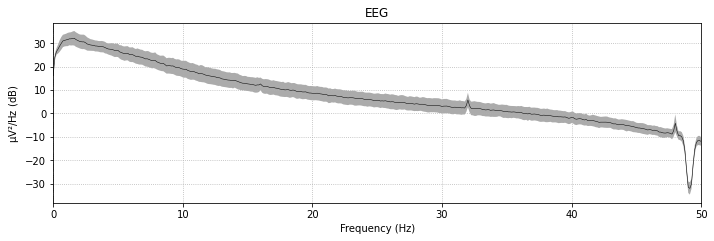

In [9]:
a.plot_psd(fmax=50,average=True)
plt.show()

In [3]:
def load_data(path, start, stop):
    """
    Uses MNE-toolbox to load the data. Apply noth filter at 50 Hz
    Input: path to file, start and stop in seconds as float
    output: the MNE.io.Raw object that contains the given time intervall
    """
    # check if path exist and then load the object with mne
    if os.path.exists(data_dir):

        raw = mne.io.read_raw_edf(path, exclude=['-', 'T8-P8', '.'], verbose=False, preload=True)

        # apply notch filter around 50 Hz.
        raw.notch_filter(freqs=[49.1, 50.9])

        # Stim channel is automatically created by MNE.
        #raw.drop_channels(['STI 014'])

        # Take 30 seconds before onset
        #start = start - 
        #stop = start + 150
        # check if the recording is long enough to create the feature vector
        if raw.n_times // 256 > start + 150:
            try:
                cropped = raw.crop(start, stop, verbose=False)
            except:
                # Sometime something goes wrong so I manually extract the seizure of the timewindow and return a
                # newly created object with the info
                manual_raw = raw.get_data()
                freq = raw.info['sfreq']
                manual_start = int(start * freq)
                manual_stop = int((stop * freq + 1))
                manual_data = np.asarray([manual_raw[i][manual_start:manual_stop] for i in range(len(manual_raw))])
                cropped = mne.io.RawArray(manual_data, raw.info, verbose=False)

        return cropped

a = load_data('data/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_06.edf',0,2000)
a

<RawArray | 21 x 512001 (2000.0 s), ~82.1 MB, data loaded>

,file_name,file_start_time,file_end_time,number_of_seizures_in_file,subject,seizure_times
0,chb01_01.edf,11:42:54,12:42:54,0,chb01,[]
1,chb01_02.edf,12:42:57,13:42:57,0,chb01,[]
2,chb01_03.edf,13:43:04,14:43:04,1,chb01,"[[2996, 3036]]"
3,chb01_04.edf,14:43:12,15:43:12,1,chb01,"[[1467, 1494]]"
4,chb01_05.edf,15:43:19,16:43:19,0,chb01,[]
...,...,...,...,...,...,...
73,chb02_31.edf,03:03:33,4:03:33,0,chb02,[]
74,chb02_32.edf,04:03:40,5:03:40,0,chb02,[]
75,chb02_33.edf,05:03:47,6:03:47,0,chb02,[]
76,chb02_34.edf,06:03:55,7:03:55,0,chb02,[]


# Process raw signals

In [4]:
for i,row in df_info.loc[25:25].iterrows():
    path = data_dir / row.file_name.split('_')[0] /row.file_name
    raw = mne.io.read_raw_edf(path, exclude=['-', 'T8-P8', '.'], verbose=False, preload=True)
    #raw.notch_filter(freqs=[60,120])

In [5]:
data, times = raw.get_data(return_times=True) # data: channel x time

# index method
#data = raw[:][0]
#times = raw[:][1]

# pick channels
#two_meg_chans_data = raw.get_data(picks=['MEG_0712', 'MEG_1022'],
#                                  start=1000, stop=2000)

data.shape

(21, 595200)

In [193]:
test = np.ndarray([["1720", "1810"],["10", "20"]])
test

TypeError: 'list' object cannot be interpreted as an integer

In [10]:
# create array of power line noise + harmonics
np.arange(60, 241, 60)

array([ 60, 120, 180, 240])

In [11]:
# data not loaded into memory (just memory mapped)
# example crop
raw.copy().crop(tmin=10, tmax=12.5)

<RawEDF | chb02_10.edf, 21 x 641 (2.5 s), ~130 kB, data loaded>

In [157]:
# info keys
list(raw.info.keys())

['acq_pars',
 'acq_stim',
 'ctf_head_t',
 'description',
 'dev_ctf_t',
 'dig',
 'experimenter',
 'utc_offset',
 'device_info',
 'file_id',
 'highpass',
 'hpi_subsystem',
 'kit_system_id',
 'helium_info',
 'line_freq',
 'lowpass',
 'meas_date',
 'meas_id',
 'proj_id',
 'proj_name',
 'subject_info',
 'xplotter_layout',
 'gantry_angle',
 'bads',
 'chs',
 'comps',
 'events',
 'hpi_meas',
 'hpi_results',
 'projs',
 'proc_history',
 'custom_ref_applied',
 'sfreq',
 'dev_head_t',
 'ch_names',
 'nchan']

## single segment

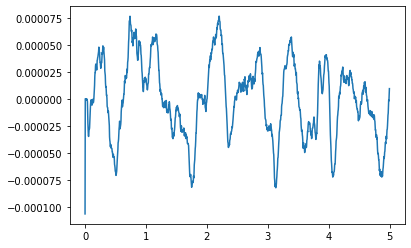

In [6]:
sampling_freq = raw.info['sfreq']
start_stop_seconds = np.array([0, 5])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
raw_selection = raw[0, start_sample:stop_sample] # can do by index or name.

x = raw_selection[1]
y = raw_selection[0].T
plt.plot(x, y)

In [8]:
win_len = 5
fs = raw.info['sfreq']
n_segments = data.shape[1]/(win_len*fs)
n_chan = raw.info["nchan"]

In [17]:
D = np.reshape(data,(n_chan,n_segments,-1)) # channel x segment x time 

## multi segments

In [6]:
# siezure time
# TODO make function (inputs df_info/raw? should be processed with loading file?)

In [12]:
def make_stats_df(X,stat_label,ch_names):
    """ turn stats array in DataFrame with stats_lable column names
    
    Args:
        X (ndarray): data matrix (segments x time)
        stat_label (string): name of the stat to append to col label
    Returns:
        df (pd.DataFrame)
    """
    df = pd.DataFrame(X, columns=[stat_label + '_' + x for x in ch_names])

    return df

def calc_segment_stats(raw,win_length=5):
    """Calculates various statistics for EEG signals.

    Args:
        raw (nme) TODO
        win_lenth (int): length of window for each segment (seconds)

    Returns:
        df_out (pd.DataFrame): segments x (channels * number of stats)

    """
    # get ndarray from raw object
    data, times = raw.get_data(return_times=True)

    # get info
    fs = raw.info['sfreq']
    n_segments = int(data.shape[1]/(win_length*fs))

    n_chan = raw.info["nchan"]

    cut = int(n_segments*win_length*fs)
    data=data[:,:cut] # remove last chunk of samples
    D = np.reshape(data,(n_chan,n_segments,-1)) # channel x segment x time


    # calc stats for segments
    m = np.mean(D,axis=2).T
    v = np.var(D,axis=2).T
    s = stats.skew(D,axis=2).T
    k = stats.kurtosis(D,axis=2).T
    sd = np.std(D,axis = 2).T

    zerox = (np.diff(np.sign(D)) != 0).sum(axis=2).T # count sign changes/zero crossings
    max_min = (np.max(D,axis=2) - np.min(D,axis=2)).T # peak-to-peak voltage

    # make data frames
    stats_list = [m,v,s,k,sd,zerox,max_min]
    labels = ["mean","variance","skew","kurtosis","std","zerox","max-min"]
    df_out = pd.concat([make_stats_df(x,y,raw.info['ch_names']) for x,y in zip(stats_list,labels)],axis=1)

    return df_out

def process_raw_chb_data(data_dir, path, win_length=5, include_ictal=True, preictal_window=None):
    """Convert raw CHB-MIT data into processed pd.DataFrames with ictal labels
    
    Processing means extracting statistics of raw signals across time windows, defined by win_length


    Args:
        data_dir (str): directory where all CHB data live
        path (pathlib.Path): path to CHB-MIT file # TODO: dont assume path file
        win_length (int): (seconds)
        include_ictal (bool):
        prectical_window (int): If None, do not incluse preictal labels, else window length in (seconds) 
    Returns:
        df_stats (pf.DataFrame):
        
    """

    raw = mne.io.read_raw_edf(path, exclude=['-', 'T8-P8', '.'], verbose=False, preload=True)
    
    df_stats = calc_segment_stats(raw, win_length)


    fs = raw.info['sfreq']


    df_info = get_summaries(data_dir) # TODO: can just load this df once somewhere else and save

    
    ## siezure labels
    if include_ictal:

        # init labels vector
        y = np.zeros(len(raw))

        fn = path.name
        row = df_info.query("file_name== @fn")
        

        if int(row.number_of_seizures_in_file) > 0:
            seizures= row.seizure_times.values[0][0] #TODO: breaks on multi siezure (second index)
            
            s, e = (seizures.astype('int') * fs).astype(int)
            y[s:e] = 1

        
        n_segments = int(len(raw)/(win_length*fs)) # dup from calc_semgment_stats()
        cut = int(n_segments*win_length*fs)
        y=y[:cut] # remove last chunk of samples

        y = np.reshape(y,(n_segments,-1))
        y = np.where(np.sum(y,axis=1)>0,1,0) # could change the 1st zero to threshold how many samples to count as siezure

        df_stats["ictal"] = y

    # TODO
    # preictal labels
    

    return df_stats


p  = Path(r"C:\code\eeg-classifier\data\chb-mit-2-subjects\chb01\chb01_20.edf")

df_full = process_raw_chb_data(data_dir, p, win_length=5)

In [56]:
y = df_full["ictal"]
X = df_full.drop(columns=["ictal"]) # may need to drop preictal

Text(0.5, 0, 'n_component')

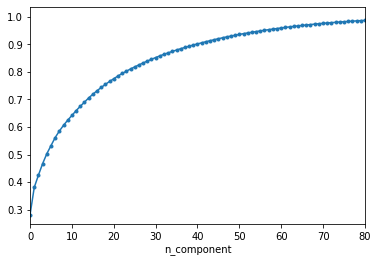

In [53]:
#pca_model = PCA(n_components=2)
pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca',PCA(svd_solver='auto'))])

X_trans = pipe.fit_transform(X)

plt.plot(np.cumsum(pipe.get_params()['pca'].explained_variance_ratio_), marker='o',markersize=3)
plt.xlim([0,80])
plt.xlabel('n_component')

Text(0, 0.5, 'PC 2')

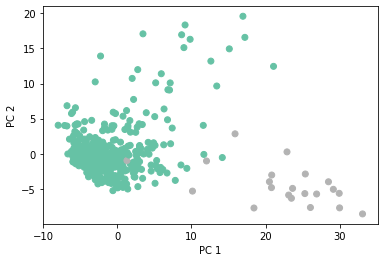

In [57]:
# fit with samller components
pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca',PCA(svd_solver='auto',n_components=50))])

X_trans = pipe.fit_transform(X)


plt.scatter(X_trans[:,0],X_trans[:,1],c=y,cmap='Set2') # y = ictal_labels
plt.xlabel('PC 1')
plt.ylabel('PC 2')

## Multi pca

In [27]:
import dask

dfs = []
#for i,row in df_info.loc[0:10].iterrows():
for i,row in df_info.iterrows():
    path = data_dir / row.file_name.split('_')[0] /row.file_name
    #print(row.file_name)
    dfs.append(dask.delayed(process_raw_chb_data)(data_dir, path, win_length=5))
    #raw.notch_filter(freqs=[60,120])


df_all = dask.delayed(pd.concat)(dfs)

#df_all.visualize()
df_all = df_all.compute()

df_all.shape

chb01_01.edf
chb01_02.edf
chb01_03.edf
chb01_04.edf
chb01_05.edf
chb01_06.edf
chb01_07.edf
chb01_08.edf
chb01_09.edf
chb01_10.edf
chb01_11.edf
chb01_12.edf
chb01_13.edf
chb01_14.edf
chb01_15.edf
chb01_16.edf
chb01_17.edf
chb01_18.edf
chb01_19.edf
chb01_20.edf
chb01_21.edf
chb01_22.edf
chb01_23.edf
chb01_24.edf
chb01_25.edf
chb01_26.edf
chb01_27.edf
chb01_29.edf
chb01_30.edf
chb01_31.edf
chb01_32.edf
chb01_33.edf
chb01_34.edf
chb01_36.edf
chb01_37.edf
chb01_38.edf
chb01_39.edf
chb01_40.edf
chb01_41.edf
chb01_42.edf
chb01_43.edf
chb01_46.edf
chb02_01.edf
chb02_02.edf
chb02_03.edf
chb02_04.edf
chb02_05.edf
chb02_06.edf
chb02_07.edf
chb02_08.edf
chb02_09.edf
chb02_10.edf
chb02_11.edf
chb02_12.edf
chb02_13.edf
chb02_14.edf
chb02_15.edf
chb02_16.edf
chb02_16+.edf
chb02_17.edf
chb02_18.edf
chb02_19.edf
chb02_20.edf
chb02_21.edf
chb02_22.edf
chb02_23.edf
chb02_24.edf
chb02_25.edf
chb02_26.edf
chb02_27.edf
chb02_28.edf
chb02_29.edf
chb02_30.edf
chb02_31.edf
chb02_32.edf
chb02_33.edf
chb02_34.ed

In [41]:
df_all.shape

(54588, 148)

In [ ]:
dfs = []
#for i,row in df_info.loc[0:10].iterrows():
for i,row in df_info.iterrows():
    path = data_dir / row.file_name.split('_')[0] /row.file_name
    print(row.file_name)
    dfs.append(process_raw_chb_data(data_dir, path, win_length=5))
    #raw.notch_filter(freqs=[60,120])


df_all = pd.concat(dfs)

Text(0, 0.5, 'PC 2')

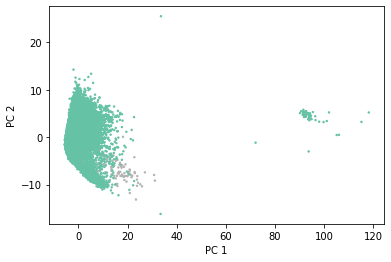

In [45]:
y = df_all["ictal"]
X = df_all.drop(columns=["ictal"]) # may need to drop preictal


# fit with samller components
pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca',PCA(svd_solver='auto',n_components=50))])

X_trans = pipe.fit_transform(X[:20000])


plt.scatter(X_trans[:,0],X_trans[:,1],c=y[:20000],cmap='Set2',s=2) # y = ictal_labels
plt.xlabel('PC 1')
plt.ylabel('PC 2')

In [35]:
sum(y)

130

In [38]:
pipe.get_params()['pca'].components_

array([[ 0.00018499, -0.00477294,  0.00054812, ...,  0.13982914,
         0.12478292,  0.13978771],
       [-0.01721245, -0.00642149,  0.0048668 , ..., -0.06519947,
        -0.03611255, -0.06543274],
       [-0.02525305, -0.00914895,  0.00315323, ..., -0.01678621,
        -0.08573631, -0.02942727],
       ...,
       [ 0.03117642,  0.01142519, -0.01366109, ..., -0.00293352,
         0.01150821, -0.04458723],
       [-0.00406778,  0.09739893,  0.01141732, ..., -0.01278623,
         0.08619326, -0.07327205],
       [ 0.01524955, -0.02446754, -0.02154308, ...,  0.05290617,
        -0.07022424,  0.0213686 ]])

In [55]:
# pca attributes (no pipe)
#pca_model.components_
#pca_model.explained_variance_ratio_

pipe.get_params()['pca'].components_

array([[-8.10154345e-03,  1.87427863e-02, -1.31230210e-02, ...,
         1.30116085e-01,  1.16888805e-01,  1.16312187e-01],
       [-1.97746385e-02,  2.63379110e-02, -2.05882227e-02, ...,
         4.72964063e-02, -3.25606542e-02,  1.11351102e-02],
       [-4.89413456e-02, -1.20129529e-02, -5.25437696e-02, ...,
        -2.81489267e-02,  4.69449393e-02,  8.64635929e-02],
       ...,
       [ 0.00000000e+00,  1.73472348e-18,  2.46830975e-01, ...,
        -4.38017678e-17, -7.82793969e-17, -1.55257751e-16],
       [ 0.00000000e+00,  4.35849273e-17, -8.06363842e-02, ...,
         1.57317735e-16, -7.37257477e-17, -9.21571847e-17],
       [-0.00000000e+00,  5.58147278e-16, -6.57360460e-02, ...,
         2.55004351e-16, -7.56935747e-16, -2.26381414e-16]])

In [58]:
from sklearn.manifold import TSNE
perp = 5
tsne_model = TSNE(n_components=2, perplexity=perp, random_state=,)

embed = tsne_model.fit_transform(X_trans)

Thes tsne plots were generated by only using data from subjects 1 and 2, PCA (k=50), the first 20,000k samples (samples = 5 sec epochs, standard stats across all channels)

Text(0.5, 1.0, 't-SNE, perplexity: 50')

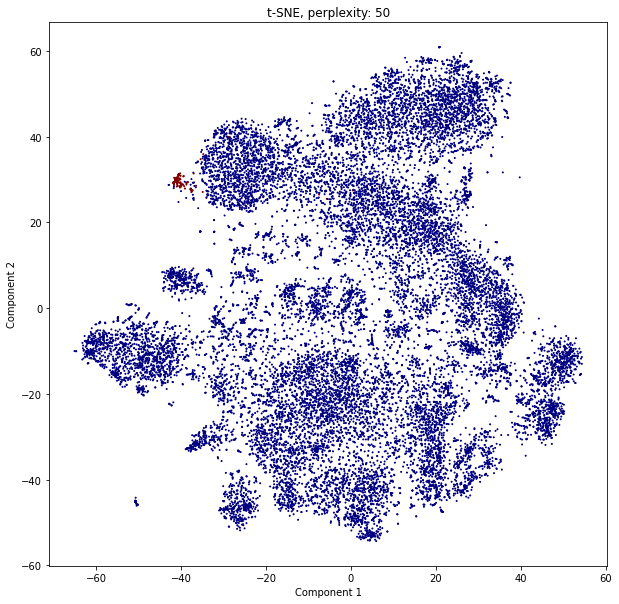

In [57]:
plt.subplots(1,figsize=(10,10))
plt.scatter(embed[:,0],embed[:,1],c=y[:20000],cmap='jet',s=1) # y = ictal_labels
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title(f"t-SNE, perplexity: {perp}")

Text(0.5, 1.0, 't-SNE, perplexity: 30')

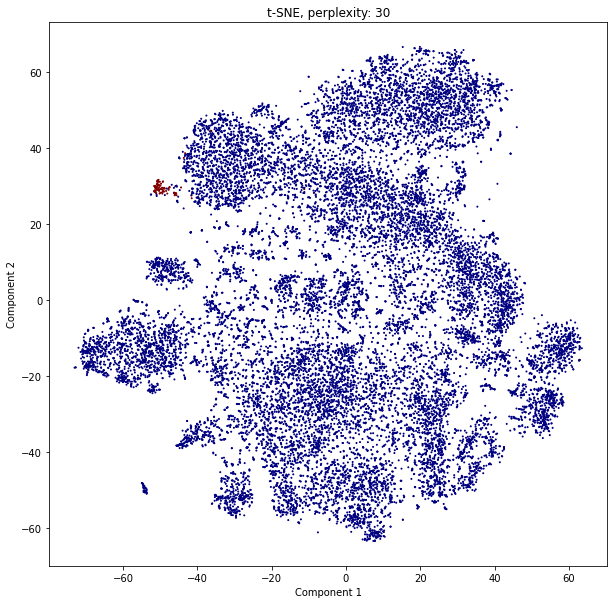

In [55]:
plt.subplots(1,figsize=(10,10))
plt.scatter(embed[:,0],embed[:,1],c=y[:20000],cmap='jet',s=1) # y = ictal_labels
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title(f"t-SNE, perplexity: {perp}")

Text(0.5, 1.0, 't-SNE, perplexity: 5')

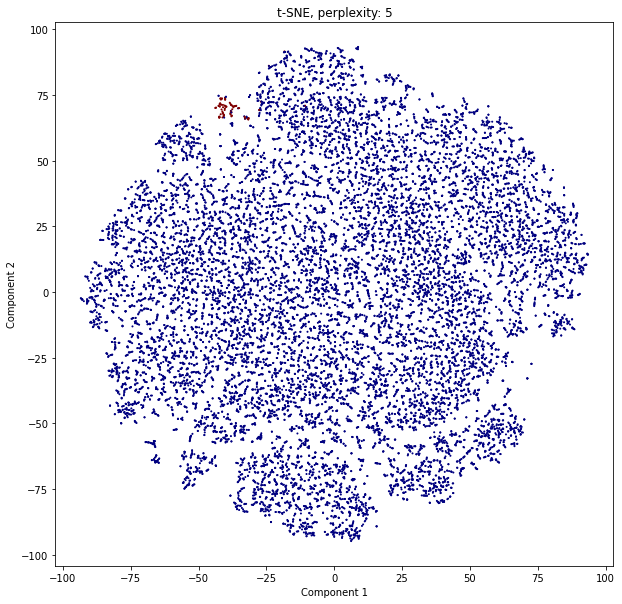

In [59]:
plt.subplots(1,figsize=(10,10))
plt.scatter(embed[:,0],embed[:,1],c=y[:20000],cmap='jet',s=1) # y = ictal_labels
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title(f"t-SNE, perplexity: {perp}")

In [61]:
from sklearn.manifold import TSNE
perp = 30
tsne_model = TSNE(n_components=2, perplexity=perp, random_state=2020,n_jobs=-1)

embed = tsne_model.fit_transform(X)

Text(0.5, 1.0, 't-SNE, noPCA, perplexity: 30')

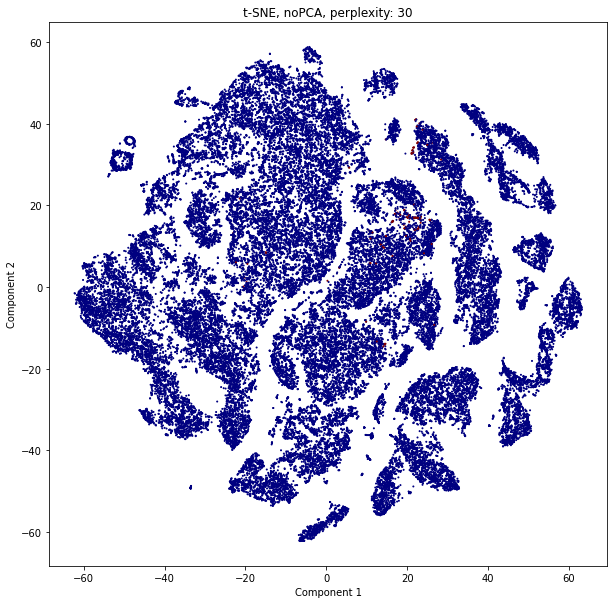

In [64]:
plt.subplots(1,figsize=(10,10))
plt.scatter(embed[:,0],embed[:,1],c=df_all["ictal"],cmap='jet',s=1) # y = ictal_labels
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title(f"t-SNE, noPCA, perplexity: {perp}")

## PSD demo

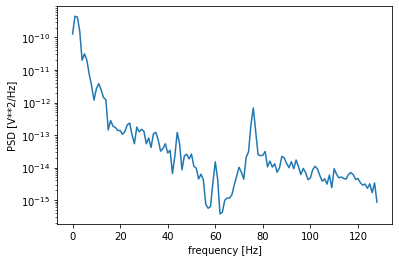

In [77]:
x,y = signal.welch(D,fs=fs,axis=2, average='median') # NEED FS
plt.semilogy(x,y[0,0,:])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

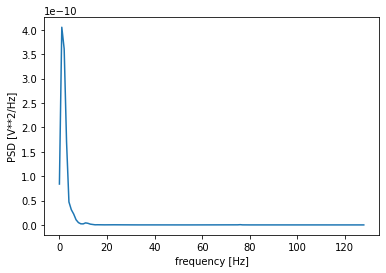

In [78]:
x,y = signal.welch(D,fs=fs,axis=2,) # NEED FS
plt.plot(x,y[0,0,:])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

## Yasa bandpower

In [76]:
import yasa
seg1 = y[:,0,:]
yasa.bandpower_from_psd(seg1, x)

,Chan,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative
0,CHAN000,0.884249,0.101698,0.014663,0.005002,0.002776,0.000716,8.633543e-10,1.0,True
1,CHAN001,0.866056,0.109987,0.023898,0.005195,0.001417,0.000375,1.531188e-09,1.0,True
2,CHAN002,0.796875,0.158286,0.027559,0.007212,0.005138,0.001075,1.736005e-09,1.0,True
3,CHAN003,0.783970,0.165553,0.036758,0.007608,0.005257,0.001191,1.360077e-09,1.0,True
4,CHAN004,0.887345,0.094566,0.018307,0.002859,0.001208,0.000213,3.640216e-09,1.0,True
5,CHAN005,0.890474,0.101768,0.009989,0.002803,0.001362,0.000218,4.032921e-09,1.0,True
6,CHAN006,0.909373,0.075735,0.017093,0.001695,0.001465,0.000367,2.277834e-09,1.0,True
7,CHAN007,0.859464,0.086603,0.031628,0.012061,0.008471,0.001120,2.144446e-09,1.0,True
8,CHAN008,0.881529,0.097641,0.014530,0.003611,0.006498,0.002279,2.960345e-09,1.0,True
9,CHAN009,0.916529,0.080068,0.011286,0.001331,0.001919,0.000581,3.050877e-09,1.0,True


In [ ]:
np.trapz(psd1)

In [73]:
psd1 = y[0,0,:]
psd1.shape

(129,)

In [82]:
np.trapz(psd1[3:7])/np.trapz(psd1)

0.15673250650095036

In [75]:
np.trapz(psd1)

1.113176278012918e-09

In [ ]:
#band power calculation
https://github.com/raphaelvallat/yasa/blob/master/notebooks/08_bandpower.ipynb

In [30]:
ft = scipy.fft.fft(r,axis=2,n=129)

In [28]:
ft.shape

(21, 720, 1280)

C:\tools\Anaconda3\envs\fastai\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


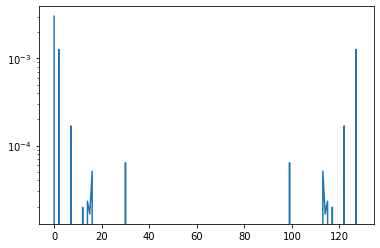

In [31]:
plt.semilogy(ft[10,6,:])


In [20]:
np.trapz(y[10,6,:],x=x)

2.4475770346526008e-09

(array([257., 280., 109.,  37.,  24.,   6.,   5.,   0.,   1.,   1.]),
 array([6.79853480e-05, 1.40776557e-04, 2.13567766e-04, 2.86358974e-04,
        3.59150183e-04, 4.31941392e-04, 5.04732601e-04, 5.77523810e-04,
        6.50315018e-04, 7.23106227e-04, 7.95897436e-04]),
 <BarContainer object of 10 artists>)

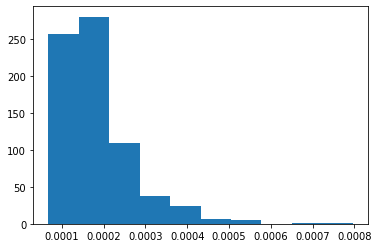

In [73]:
plt.hist(max_min[0])

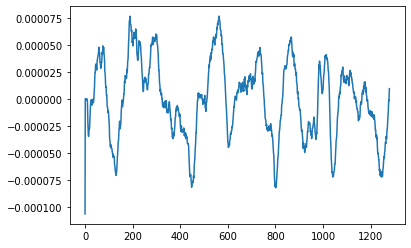

In [48]:
plt.plot(r[0,0,:])

In [66]:
(np.diff(np.sign(r[0,0,:])) != 0).sum()

27

In [53]:
np.mean(r[0,1,:])

9.9053724053724e-07

In [54]:
np.array_split(data,n_segments,axis=1).shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
data.

<RawEDF | chb02_10.edf, 21 x 921600 (3600.0 s), ~147.7 MB, data loaded>

Setting up low-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB



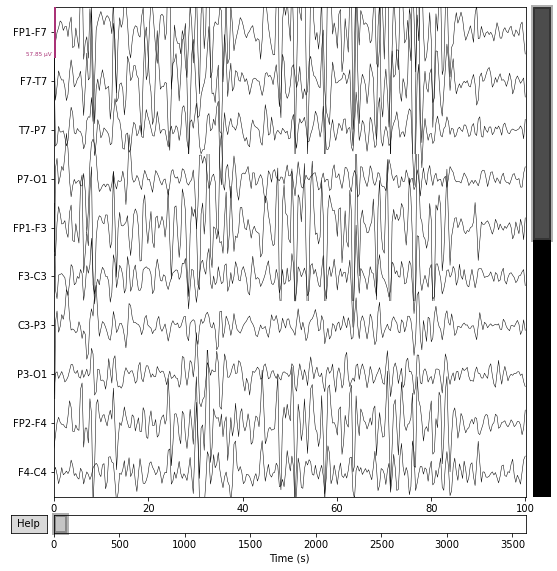

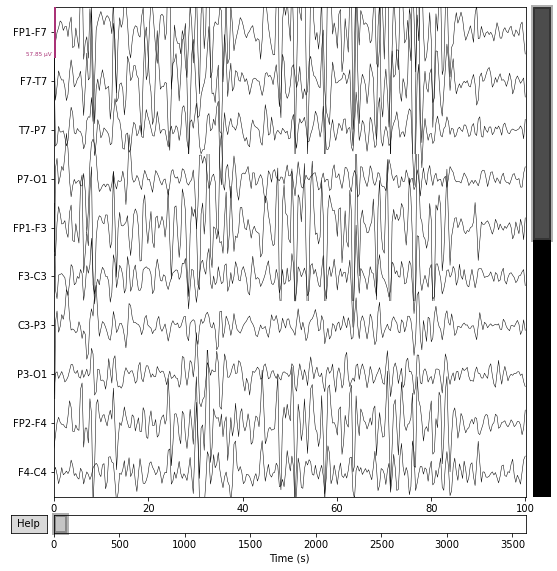

In [34]:
raw.plot(duration=100, n_channels=10,scalings='auto',lowpass=True)

<ipython-input-15-a5fcf744740b>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()


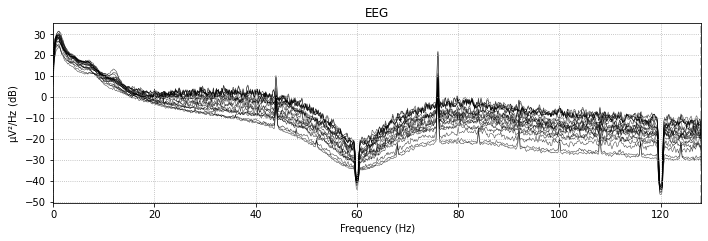

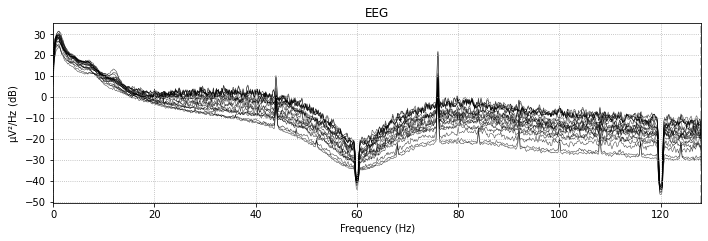

In [15]:
raw.plot_psd()